In [4]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [5]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [6]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [7]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
    
    
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=5000)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
    
    print(f"{0}:{dataFinal.shape}")
    
    '''
    0: 5000
    1:2500*2
        2: 1000*5
            3:250*20
                4: 250*20
                    5: 50*100
                
    '''
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        
        '''
        num_s = 0
        if i == 1:
            num_s = 2
        if i == 2:
            num_s = 5
        if i == 3:
            num_s = 20
        if i == 4:
            num_s = 20     
        if i == 5:
            num_s = 100
            '''
        
        if i in [2,4]:
            sample_n = 7500
            
        if i == 3:
            sample_n = 8500
        elif i == 0:
            sample_n = 8000
        elif i == 1:
            sample_n = 8500
            
        else:
            sample_n = 5000
        
        curr_num_sub = curr_num.sample(n=sample_n, replace = True)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [8]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(8500, 55)
2:(5000, 55)
3:(8500, 55)
4:(5000, 55)
5:(5000, 55)
(37000, 55)
[0. 1. 2. 3. 4. 5.]
(37000, 51) (37000, 6)


In [9]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-05-31 06:01:26.572806: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 06:01:26.572879: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-05-31 06:01:26.577900: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.13439189189189188
0: 3978
1: 0.22797297297297298
1: 6748
2: 0.13577702702702701
2: 4019
3: 0.23087837837837838
3: 6834
4: 0.1347635135135135
4: 3989
5: 0.1362162162162162
5: 4032

TEST DISTRIBUTION
0: 0.1437837837837838
1: 0.2308108108108108
2: 0.1308108108108108
3: 0.21945945945945947
4: 0.1362162162162162
5: 0.13891891891891892


In [10]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.31810256 0.53960685 0.32138114 0.54648388 0.31898218 0.32242069]
[3.143640229572653, 1.8532010719087155, 3.111570249624288, 1.8298801336318424, 3.134971379603914, 3.1015379050694474]


In [11]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [12]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [14]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [16]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
1839/1850 [============================>.] - ETA: 0s - loss: 0.1843 - tp: 5144.0000 - fp: 952.0000 - tn: 146168.0000 - fn: 24280.0000 - accuracy: 0.8571 - precision: 0.8438 - recall: 0.1748 - auc: 0.8982 - prc: 0.6551
Epoch 1: val_loss improved from inf to 0.12582, saving model to weights.best.onlyfocalloss


2022-05-31 06:02:26.437441: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 18s 7ms/step - loss: 0.1841 - tp: 5200.0000 - fp: 962.0000 - tn: 147038.0000 - fn: 24400.0000 - accuracy: 0.8572 - precision: 0.8439 - recall: 0.1757 - auc: 0.8984 - prc: 0.6557 - val_loss: 0.1258 - val_tp: 1342.0000 - val_fp: 118.0000 - val_tn: 18382.0000 - val_fn: 2358.0000 - val_accuracy: 0.8885 - val_precision: 0.9192 - val_recall: 0.3627 - val_auc: 0.9551 - val_prc: 0.8328
Epoch 2/200
1846/1850 [============================>.] - ETA: 0s - loss: 0.1352 - tp: 11304.0000 - fp: 1478.0000 - tn: 146202.0000 - fn: 18232.0000 - accuracy: 0.8888 - precision: 0.8844 - recall: 0.3827 - auc: 0.9472 - prc: 0.7952
Epoch 2: val_loss improved from 0.12582 to 0.11027, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 11s 6ms/step - loss: 0.1352 - tp: 11331.0000 - fp: 1483.0000 - t

Epoch 12/200
1841/1850 [============================>.] - ETA: 0s - loss: 0.0982 - tp: 17662.0000 - fp: 1616.0000 - tn: 145664.0000 - fn: 11794.0000 - accuracy: 0.9241 - precision: 0.9162 - recall: 0.5996 - auc: 0.9730 - prc: 0.8917
Epoch 12: val_loss improved from 0.08420 to 0.08227, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 12s 7ms/step - loss: 0.0983 - tp: 17750.0000 - fp: 1625.0000 - tn: 146375.0000 - fn: 11850.0000 - accuracy: 0.9241 - precision: 0.9161 - recall: 0.5997 - auc: 0.9729 - prc: 0.8916 - val_loss: 0.0823 - val_tp: 2422.0000 - val_fp: 170.0000 - val_tn: 18330.0000 - val_fn: 1278.0000 - val_accuracy: 0.9348 - val_precision: 0.9344 - val_recall: 0.6546 - val_auc: 0.9815 - val_prc: 0.9228
Epoch 13/200
1849/1850 [============================>.] - ETA: 0s - loss: 0.0969 - tp: 17916.0000 - fp: 1604.0000 - tn: 146316.0000 - fn: 11668.0000 - accuracy: 0.9252 - prec

Epoch 23/200
1850/1850 [==============================] - ETA: 0s - loss: 0.0905 - tp: 18919.0000 - fp: 1539.0000 - tn: 146461.0000 - fn: 10681.0000 - accuracy: 0.9312 - precision: 0.9248 - recall: 0.6392 - auc: 0.9774 - prc: 0.9083
Epoch 23: val_loss did not improve from 0.07394
1850/1850 [==============================] - 8s 4ms/step - loss: 0.0905 - tp: 18919.0000 - fp: 1539.0000 - tn: 146461.0000 - fn: 10681.0000 - accuracy: 0.9312 - precision: 0.9248 - recall: 0.6392 - auc: 0.9774 - prc: 0.9083 - val_loss: 0.0741 - val_tp: 2617.0000 - val_fp: 161.0000 - val_tn: 18339.0000 - val_fn: 1083.0000 - val_accuracy: 0.9440 - val_precision: 0.9420 - val_recall: 0.7073 - val_auc: 0.9851 - val_prc: 0.9380
Epoch 24/200
1846/1850 [============================>.] - ETA: 0s - loss: 0.0891 - tp: 19096.0000 - fp: 1542.0000 - tn: 146138.0000 - fn: 10440.0000 - accuracy: 0.9324 - precision: 0.9253 - recall: 0.6465 - auc: 0.9782 - prc: 0.9105
Epoch 24: val_loss improved from 0.07394 to 0.07218, saving

Epoch 34/200
1848/1850 [============================>.] - ETA: 0s - loss: 0.0853 - tp: 19575.0000 - fp: 1461.0000 - tn: 146379.0000 - fn: 9993.0000 - accuracy: 0.9354 - precision: 0.9305 - recall: 0.6620 - auc: 0.9801 - prc: 0.9191
Epoch 34: val_loss did not improve from 0.06835
1850/1850 [==============================] - 10s 5ms/step - loss: 0.0853 - tp: 19594.0000 - fp: 1463.0000 - tn: 146537.0000 - fn: 10006.0000 - accuracy: 0.9354 - precision: 0.9305 - recall: 0.6620 - auc: 0.9801 - prc: 0.9191 - val_loss: 0.0703 - val_tp: 2630.0000 - val_fp: 139.0000 - val_tn: 18361.0000 - val_fn: 1070.0000 - val_accuracy: 0.9455 - val_precision: 0.9498 - val_recall: 0.7108 - val_auc: 0.9866 - val_prc: 0.9447
Epoch 35/200
1842/1850 [============================>.] - ETA: 0s - loss: 0.0849 - tp: 19533.0000 - fp: 1473.0000 - tn: 145887.0000 - fn: 9939.0000 - accuracy: 0.9355 - precision: 0.9299 - recall: 0.6628 - auc: 0.9802 - prc: 0.9198
Epoch 35: val_loss did not improve from 0.06835
1850/1850 [=

Epoch 45/200
1843/1850 [============================>.] - ETA: 0s - loss: 0.0821 - tp: 20136.0000 - fp: 1485.0000 - tn: 145955.0000 - fn: 9352.0000 - accuracy: 0.9387 - precision: 0.9313 - recall: 0.6829 - auc: 0.9817 - prc: 0.9248
Epoch 45: val_loss did not improve from 0.06364
1850/1850 [==============================] - 9s 5ms/step - loss: 0.0820 - tp: 20222.0000 - fp: 1488.0000 - tn: 146512.0000 - fn: 9378.0000 - accuracy: 0.9388 - precision: 0.9315 - recall: 0.6832 - auc: 0.9817 - prc: 0.9250 - val_loss: 0.0640 - val_tp: 2714.0000 - val_fp: 133.0000 - val_tn: 18367.0000 - val_fn: 986.0000 - val_accuracy: 0.9496 - val_precision: 0.9533 - val_recall: 0.7335 - val_auc: 0.9891 - val_prc: 0.9537
Epoch 46/200
1842/1850 [============================>.] - ETA: 0s - loss: 0.0827 - tp: 19955.0000 - fp: 1429.0000 - tn: 145931.0000 - fn: 9517.0000 - accuracy: 0.9381 - precision: 0.9332 - recall: 0.6771 - auc: 0.9814 - prc: 0.9241
Epoch 46: val_loss did not improve from 0.06364
1850/1850 [====

Epoch 56/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.0807 - tp: 20413.0000 - fp: 1444.0000 - tn: 146156.0000 - fn: 9107.0000 - accuracy: 0.9404 - precision: 0.9339 - recall: 0.6915 - auc: 0.9824 - prc: 0.9278
Epoch 56: val_loss did not improve from 0.06248
1850/1850 [==============================] - 9s 5ms/step - loss: 0.0807 - tp: 20465.0000 - fp: 1448.0000 - tn: 146552.0000 - fn: 9135.0000 - accuracy: 0.9404 - precision: 0.9339 - recall: 0.6914 - auc: 0.9824 - prc: 0.9278 - val_loss: 0.0642 - val_tp: 2678.0000 - val_fp: 117.0000 - val_tn: 18383.0000 - val_fn: 1022.0000 - val_accuracy: 0.9487 - val_precision: 0.9581 - val_recall: 0.7238 - val_auc: 0.9892 - val_prc: 0.9541
Epoch 57/200
1844/1850 [============================>.] - ETA: 0s - loss: 0.0809 - tp: 20255.0000 - fp: 1419.0000 - tn: 146101.0000 - fn: 9249.0000 - accuracy: 0.9397 - precision: 0.9345 - recall: 0.6865 - auc: 0.9822 - prc: 0.9272
Epoch 57: val_loss improved from 0.06248 to 0.06068, saving mo

1843/1850 [============================>.] - ETA: 0s - loss: 0.0786 - tp: 20595.0000 - fp: 1387.0000 - tn: 146053.0000 - fn: 8893.0000 - accuracy: 0.9419 - precision: 0.9369 - recall: 0.6984 - auc: 0.9833 - prc: 0.9316
Epoch 67: val_loss did not improve from 0.05964
1850/1850 [==============================] - 8s 4ms/step - loss: 0.0785 - tp: 20675.0000 - fp: 1391.0000 - tn: 146609.0000 - fn: 8925.0000 - accuracy: 0.9419 - precision: 0.9370 - recall: 0.6985 - auc: 0.9833 - prc: 0.9316 - val_loss: 0.0624 - val_tp: 2706.0000 - val_fp: 118.0000 - val_tn: 18382.0000 - val_fn: 994.0000 - val_accuracy: 0.9499 - val_precision: 0.9582 - val_recall: 0.7314 - val_auc: 0.9899 - val_prc: 0.9567
Epoch 68/200
1841/1850 [============================>.] - ETA: 0s - loss: 0.0786 - tp: 20526.0000 - fp: 1374.0000 - tn: 145906.0000 - fn: 8930.0000 - accuracy: 0.9417 - precision: 0.9373 - recall: 0.6968 - auc: 0.9833 - prc: 0.9314
Epoch 68: val_loss did not improve from 0.05964
1850/1850 [=================

1844/1850 [============================>.] - ETA: 0s - loss: 0.0777 - tp: 20772.0000 - fp: 1348.0000 - tn: 146172.0000 - fn: 8732.0000 - accuracy: 0.9431 - precision: 0.9391 - recall: 0.7040 - auc: 0.9838 - prc: 0.9333
Epoch 78: val_loss did not improve from 0.05796
1850/1850 [==============================] - 9s 5ms/step - loss: 0.0777 - tp: 20839.0000 - fp: 1351.0000 - tn: 146649.0000 - fn: 8761.0000 - accuracy: 0.9431 - precision: 0.9391 - recall: 0.7040 - auc: 0.9838 - prc: 0.9334 - val_loss: 0.0590 - val_tp: 2743.0000 - val_fp: 103.0000 - val_tn: 18397.0000 - val_fn: 957.0000 - val_accuracy: 0.9523 - val_precision: 0.9638 - val_recall: 0.7414 - val_auc: 0.9912 - val_prc: 0.9623
Epoch 79/200
1849/1850 [============================>.] - ETA: 0s - loss: 0.0770 - tp: 20811.0000 - fp: 1421.0000 - tn: 146499.0000 - fn: 8773.0000 - accuracy: 0.9426 - precision: 0.9361 - recall: 0.7035 - auc: 0.9840 - prc: 0.9342
Epoch 79: val_loss did not improve from 0.05796
1850/1850 [=================

Epoch 90/200
1844/1850 [============================>.] - ETA: 0s - loss: 0.0769 - tp: 20967.0000 - fp: 1360.0000 - tn: 146160.0000 - fn: 8537.0000 - accuracy: 0.9441 - precision: 0.9391 - recall: 0.7106 - auc: 0.9842 - prc: 0.9351
Epoch 90: val_loss did not improve from 0.05638
1850/1850 [==============================] - 8s 5ms/step - loss: 0.0768 - tp: 21031.0000 - fp: 1362.0000 - tn: 146638.0000 - fn: 8569.0000 - accuracy: 0.9441 - precision: 0.9392 - recall: 0.7105 - auc: 0.9843 - prc: 0.9352 - val_loss: 0.0582 - val_tp: 2766.0000 - val_fp: 107.0000 - val_tn: 18393.0000 - val_fn: 934.0000 - val_accuracy: 0.9531 - val_precision: 0.9628 - val_recall: 0.7476 - val_auc: 0.9914 - val_prc: 0.9634
Epoch 91/200
1833/1850 [============================>.] - ETA: 0s - loss: 0.0766 - tp: 20869.0000 - fp: 1355.0000 - tn: 145285.0000 - fn: 8459.0000 - accuracy: 0.9442 - precision: 0.9390 - recall: 0.7116 - auc: 0.9842 - prc: 0.9355
Epoch 91: val_loss did not improve from 0.05638
1850/1850 [====

Epoch 102/200
1847/1850 [============================>.] - ETA: 0s - loss: 0.0765 - tp: 21035.0000 - fp: 1384.0000 - tn: 146376.0000 - fn: 8517.0000 - accuracy: 0.9442 - precision: 0.9383 - recall: 0.7118 - auc: 0.9844 - prc: 0.9364
Epoch 102: val_loss did not improve from 0.05632
1850/1850 [==============================] - 9s 5ms/step - loss: 0.0765 - tp: 21071.0000 - fp: 1386.0000 - tn: 146614.0000 - fn: 8529.0000 - accuracy: 0.9442 - precision: 0.9383 - recall: 0.7119 - auc: 0.9844 - prc: 0.9364 - val_loss: 0.0602 - val_tp: 2746.0000 - val_fp: 95.0000 - val_tn: 18405.0000 - val_fn: 954.0000 - val_accuracy: 0.9527 - val_precision: 0.9666 - val_recall: 0.7422 - val_auc: 0.9907 - val_prc: 0.9609
Epoch 103/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.0745 - tp: 21167.0000 - fp: 1323.0000 - tn: 146277.0000 - fn: 8353.0000 - accuracy: 0.9454 - precision: 0.9412 - recall: 0.7170 - auc: 0.9849 - prc: 0.9386
Epoch 103: val_loss improved from 0.05632 to 0.05598, saving 

Epoch 113/200
1847/1850 [============================>.] - ETA: 0s - loss: 0.0741 - tp: 21393.0000 - fp: 1347.0000 - tn: 146413.0000 - fn: 8159.0000 - accuracy: 0.9464 - precision: 0.9408 - recall: 0.7239 - auc: 0.9854 - prc: 0.9399
Epoch 113: val_loss did not improve from 0.05445
1850/1850 [==============================] - 8s 5ms/step - loss: 0.0740 - tp: 21433.0000 - fp: 1348.0000 - tn: 146652.0000 - fn: 8167.0000 - accuracy: 0.9464 - precision: 0.9408 - recall: 0.7241 - auc: 0.9854 - prc: 0.9400 - val_loss: 0.0560 - val_tp: 2857.0000 - val_fp: 117.0000 - val_tn: 18383.0000 - val_fn: 843.0000 - val_accuracy: 0.9568 - val_precision: 0.9607 - val_recall: 0.7722 - val_auc: 0.9918 - val_prc: 0.9648
Epoch 114/200
1846/1850 [============================>.] - ETA: 0s - loss: 0.0741 - tp: 21369.0000 - fp: 1318.0000 - tn: 146362.0000 - fn: 8167.0000 - accuracy: 0.9465 - precision: 0.9419 - recall: 0.7235 - auc: 0.9853 - prc: 0.9400
Epoch 114: val_loss did not improve from 0.05445
1850/1850 [

1845/1850 [============================>.] - ETA: 0s - loss: 0.0724 - tp: 21533.0000 - fp: 1334.0000 - tn: 146266.0000 - fn: 7987.0000 - accuracy: 0.9474 - precision: 0.9417 - recall: 0.7294 - auc: 0.9858 - prc: 0.9423
Epoch 124: val_loss did not improve from 0.05280
1850/1850 [==============================] - 10s 5ms/step - loss: 0.0725 - tp: 21587.0000 - fp: 1340.0000 - tn: 146660.0000 - fn: 8013.0000 - accuracy: 0.9473 - precision: 0.9416 - recall: 0.7293 - auc: 0.9858 - prc: 0.9422 - val_loss: 0.0540 - val_tp: 2907.0000 - val_fp: 126.0000 - val_tn: 18374.0000 - val_fn: 793.0000 - val_accuracy: 0.9586 - val_precision: 0.9585 - val_recall: 0.7857 - val_auc: 0.9925 - val_prc: 0.9677
Epoch 125/200
1847/1850 [============================>.] - ETA: 0s - loss: 0.0726 - tp: 21580.0000 - fp: 1343.0000 - tn: 146417.0000 - fn: 7972.0000 - accuracy: 0.9475 - precision: 0.9414 - recall: 0.7302 - auc: 0.9858 - prc: 0.9419
Epoch 125: val_loss did not improve from 0.05280
1850/1850 [=============

Epoch 136/200
1838/1850 [============================>.] - ETA: 0s - loss: 0.0722 - tp: 21479.0000 - fp: 1349.0000 - tn: 145691.0000 - fn: 7929.0000 - accuracy: 0.9474 - precision: 0.9409 - recall: 0.7304 - auc: 0.9859 - prc: 0.9426
Epoch 136: val_loss did not improve from 0.05280
1850/1850 [==============================] - 8s 4ms/step - loss: 0.0722 - tp: 21612.0000 - fp: 1358.0000 - tn: 146642.0000 - fn: 7988.0000 - accuracy: 0.9474 - precision: 0.9409 - recall: 0.7301 - auc: 0.9859 - prc: 0.9426 - val_loss: 0.0537 - val_tp: 2906.0000 - val_fp: 108.0000 - val_tn: 18392.0000 - val_fn: 794.0000 - val_accuracy: 0.9594 - val_precision: 0.9642 - val_recall: 0.7854 - val_auc: 0.9926 - val_prc: 0.9685
Epoch 137/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.0722 - tp: 21629.0000 - fp: 1311.0000 - tn: 146289.0000 - fn: 7891.0000 - accuracy: 0.9480 - precision: 0.9429 - recall: 0.7327 - auc: 0.9861 - prc: 0.9433
Epoch 137: val_loss did not improve from 0.05280
1850/1850 [

Epoch 148/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.0718 - tp: 21680.0000 - fp: 1276.0000 - tn: 146324.0000 - fn: 7840.0000 - accuracy: 0.9485 - precision: 0.9444 - recall: 0.7344 - auc: 0.9862 - prc: 0.9437
Epoch 148: val_loss did not improve from 0.05225
1850/1850 [==============================] - 8s 5ms/step - loss: 0.0719 - tp: 21735.0000 - fp: 1282.0000 - tn: 146718.0000 - fn: 7865.0000 - accuracy: 0.9485 - precision: 0.9443 - recall: 0.7343 - auc: 0.9862 - prc: 0.9437 - val_loss: 0.0546 - val_tp: 2861.0000 - val_fp: 107.0000 - val_tn: 18393.0000 - val_fn: 839.0000 - val_accuracy: 0.9574 - val_precision: 0.9639 - val_recall: 0.7732 - val_auc: 0.9922 - val_prc: 0.9669
Epoch 149/200
1840/1850 [============================>.] - ETA: 0s - loss: 0.0719 - tp: 21627.0000 - fp: 1256.0000 - tn: 145944.0000 - fn: 7813.0000 - accuracy: 0.9487 - precision: 0.9451 - recall: 0.7346 - auc: 0.9862 - prc: 0.9439
Epoch 149: val_loss did not improve from 0.05225
1850/1850 [

1845/1850 [============================>.] - ETA: 0s - loss: 0.0712 - tp: 21703.0000 - fp: 1302.0000 - tn: 146298.0000 - fn: 7817.0000 - accuracy: 0.9485 - precision: 0.9434 - recall: 0.7352 - auc: 0.9863 - prc: 0.9442
Epoch 159: val_loss did not improve from 0.05092
1850/1850 [==============================] - 8s 4ms/step - loss: 0.0712 - tp: 21767.0000 - fp: 1303.0000 - tn: 146697.0000 - fn: 7833.0000 - accuracy: 0.9486 - precision: 0.9435 - recall: 0.7354 - auc: 0.9863 - prc: 0.9442 - val_loss: 0.0532 - val_tp: 2930.0000 - val_fp: 133.0000 - val_tn: 18367.0000 - val_fn: 770.0000 - val_accuracy: 0.9593 - val_precision: 0.9566 - val_recall: 0.7919 - val_auc: 0.9928 - val_prc: 0.9684
Epoch 160/200
1840/1850 [============================>.] - ETA: 0s - loss: 0.0717 - tp: 21596.0000 - fp: 1284.0000 - tn: 145916.0000 - fn: 7844.0000 - accuracy: 0.9483 - precision: 0.9439 - recall: 0.7336 - auc: 0.9864 - prc: 0.9439
Epoch 160: val_loss did not improve from 0.05092
1850/1850 [==============

Epoch 171/200
1850/1850 [==============================] - ETA: 0s - loss: 0.0705 - tp: 22025.0000 - fp: 1306.0000 - tn: 146694.0000 - fn: 7575.0000 - accuracy: 0.9500 - precision: 0.9440 - recall: 0.7441 - auc: 0.9868 - prc: 0.9461
Epoch 171: val_loss did not improve from 0.05025
1850/1850 [==============================] - 9s 5ms/step - loss: 0.0705 - tp: 22025.0000 - fp: 1306.0000 - tn: 146694.0000 - fn: 7575.0000 - accuracy: 0.9500 - precision: 0.9440 - recall: 0.7441 - auc: 0.9868 - prc: 0.9461 - val_loss: 0.0506 - val_tp: 3000.0000 - val_fp: 108.0000 - val_tn: 18392.0000 - val_fn: 700.0000 - val_accuracy: 0.9636 - val_precision: 0.9653 - val_recall: 0.8108 - val_auc: 0.9934 - val_prc: 0.9719
Epoch 172/200
1844/1850 [============================>.] - ETA: 0s - loss: 0.0702 - tp: 21990.0000 - fp: 1341.0000 - tn: 146179.0000 - fn: 7514.0000 - accuracy: 0.9500 - precision: 0.9425 - recall: 0.7453 - auc: 0.9869 - prc: 0.9464
Epoch 172: val_loss did not improve from 0.05025
1850/1850 [

Epoch 183/200
1848/1850 [============================>.] - ETA: 0s - loss: 0.0704 - tp: 21939.0000 - fp: 1303.0000 - tn: 146537.0000 - fn: 7629.0000 - accuracy: 0.9497 - precision: 0.9439 - recall: 0.7420 - auc: 0.9869 - prc: 0.9460
Epoch 183: val_loss did not improve from 0.04923
1850/1850 [==============================] - 7s 4ms/step - loss: 0.0705 - tp: 21960.0000 - fp: 1303.0000 - tn: 146697.0000 - fn: 7640.0000 - accuracy: 0.9496 - precision: 0.9440 - recall: 0.7419 - auc: 0.9869 - prc: 0.9459 - val_loss: 0.0527 - val_tp: 2950.0000 - val_fp: 129.0000 - val_tn: 18371.0000 - val_fn: 750.0000 - val_accuracy: 0.9604 - val_precision: 0.9581 - val_recall: 0.7973 - val_auc: 0.9927 - val_prc: 0.9690
Epoch 184/200
1840/1850 [============================>.] - ETA: 0s - loss: 0.0695 - tp: 21955.0000 - fp: 1283.0000 - tn: 145917.0000 - fn: 7485.0000 - accuracy: 0.9504 - precision: 0.9448 - recall: 0.7458 - auc: 0.9872 - prc: 0.9471
Epoch 184: val_loss did not improve from 0.04923
1850/1850 [

Epoch 195/200
1842/1850 [============================>.] - ETA: 0s - loss: 0.0691 - tp: 21918.0000 - fp: 1267.0000 - tn: 146093.0000 - fn: 7554.0000 - accuracy: 0.9501 - precision: 0.9454 - recall: 0.7437 - auc: 0.9872 - prc: 0.9474
Epoch 195: val_loss did not improve from 0.04907
1850/1850 [==============================] - 8s 4ms/step - loss: 0.0692 - tp: 22013.0000 - fp: 1274.0000 - tn: 146726.0000 - fn: 7587.0000 - accuracy: 0.9501 - precision: 0.9453 - recall: 0.7437 - auc: 0.9872 - prc: 0.9474 - val_loss: 0.0492 - val_tp: 2990.0000 - val_fp: 104.0000 - val_tn: 18396.0000 - val_fn: 710.0000 - val_accuracy: 0.9633 - val_precision: 0.9664 - val_recall: 0.8081 - val_auc: 0.9938 - val_prc: 0.9736
Epoch 196/200
1844/1850 [============================>.] - ETA: 0s - loss: 0.0698 - tp: 21923.0000 - fp: 1244.0000 - tn: 146276.0000 - fn: 7581.0000 - accuracy: 0.9501 - precision: 0.9463 - recall: 0.7431 - auc: 0.9870 - prc: 0.9467
Epoch 196: val_loss did not improve from 0.04907
1850/1850 [

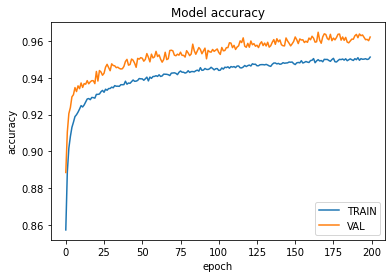

In [17]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

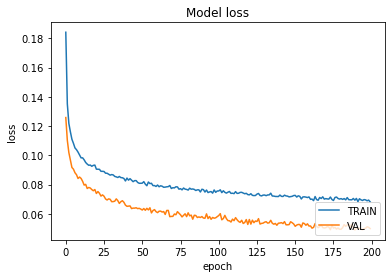

In [18]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [19]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

116/116 [==============================] - 0s 3ms/step - loss: 0.0770 - tp: 2391.0000 - fp: 83.0000 - tn: 18417.0000 - fn: 1309.0000 - accuracy: 0.9373 - precision: 0.9665 - recall: 0.6462 - auc: 0.9829 - prc: 0.9353


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.73      0.82       532
           1       0.84      0.83      0.83       854
           2       0.78      0.88      0.83       484
           3       0.81      0.85      0.83       812
           4       0.86      0.88      0.87       504
           5       0.94      1.00      0.97       514

    accuracy                           0.86      3700
   macro avg       0.87      0.86      0.86      3700
weighted avg       0.86      0.86      0.86      3700



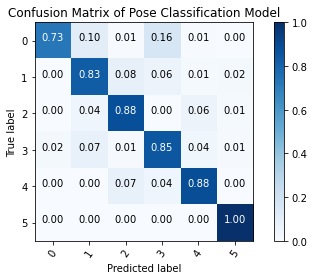

In [20]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [21]:
#Classes 3, 4 Need to be weighted

